## Running this notebook

You can launch this notebook using mybinder by clicking the button below.

<a href="https://mybinder.org/v2/gh/US-GHG-Center/ghgc-docs/HEAD?labpath=user_data_notebooks/wetland_methane_emissions.ipynb">
<img src="https://mybinder.org/badge_logo.svg" alt="Binder" title="A cute binder" width="150"/> 
</a>

## Approach

1. Identify available dates and temporal frequency of observations for the given collection using the GHGC API `/stac` endpoint. The collection processed in this notebook is the Wetland Methane Emissions, LPJ-wsl Model data product.
2. Pass the STAC item into the raster API `/stac/tilejson.json `endpoint.
3. Using `folium.plugins.DualMap`, visualize two tiles (side-by-side), allowing time point comparison.
4. After the visualization, perform zonal statistics for a given polygon.

   

## About the Data

Methane (CH₄) emissions from wetlands are estimated to be the largest natural source of methane in the global CH₄ budget, contributing to roughly one third of the total of natural and anthropogenic emissions. Wetland CH₄ is produced by microbes breaking down organic matter in the oxygen deprived environment of inundated soils. Due to limited data availability, the details of the role of wetland CH₄ emissions has thus far been underrepresented. Using the Wald Schnee und Landschaft version (LPJ-wsl) of the Lund-Potsdam-Jena Dynamic Global Vegetation Model (LPJ-DGVM) global CH₄ emissions from wetlands are estimated at 0.5 x 0.5 degree resolution by simulating wetland extent and using characteristics of these inundated areas, such as soil moisture, temperature, and carbon content, to estimate CH₄ quantities emitted into the atmosphere. Highlighted areas displayed in this dataset show concentrated methane sources from tropical and high latitude ecosystems. The LPJ-wsl Wetland Methane Emissions data product presented here consists of global daily and monthly model estimates of terrestrial wetland CH₄ emissions from 1980 - 2021. These data are regularly used in conjunction with NASA’s Goddard Earth Observing System (GEOS) model to simulate the impact of wetlands and other methane sources on atmospheric methane concentrations, to compare against satellite and airborne data, and to improve understanding and prediction of wetland emissions.

# Installing the Required Libraries
Please run the next cell to install all the required libraries to run the notebook.

In [ ]:
%pip install requests
%pip install folium
%pip install rasterstats
%pip install pystac_client

## Querying the STAC API

In [1]:
import requests
from folium import Map, TileLayer
from pystac_client import Client

In [2]:
# Provide STAC and RASTER API endpoints
STAC_API_URL = "http://ghg.center/api/stac"
RASTER_API_URL = "https://ghg.center/api/raster"

# Please use the collection name similar to the one used in STAC collection.

# Name of the collection for wetland methane monthly emissions. 
collection_name = "nasa-gsfc-ch4-wetlands-emissions"

In [3]:
# Fetching the collection from STAC collections using appropriate endpoint.
collection = requests.get(f"{STAC_API_URL}/collections/{collection_name}").json()
collection

{'id': 'nasa-gsfc-ch4-wetlands-emissions',
 'type': 'Collection',
 'links': [{'rel': 'items',
   'type': 'application/geo+json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/collections/nasa-gsfc-ch4-wetlands-emissions/items'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/'},
  {'rel': 'self',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/collections/nasa-gsfc-ch4-wetlands-emissions'}],
 'title': 'LPJ-wsl CH4 Wetland Emissions',
 'assets': None,
 'extent': {'spatial': {'bbox': [[-180, -90, 180, 90]]},
  'temporal': {'interval': [['1980-01-01 00:00:00+00',
     '2021-12-01 00:00:00+00']]}},
 'license': 'CC BY 4.0',
 'keywords': None,
 'providers': None,
 'summaries': {'datetime': ['1980-01

Examining the contents of our `collection` under `summaries`, we see that the data is available from January 1980 to December 2021. By looking at `dashboard: time density`, we can see that these observations are collected monthly.

In [4]:
# Check total number of items available
items = requests.get(f"{STAC_API_URL}/collections/{collection_name}/items?limit=300").json()["features"]
print(f"Found {len(items)} items")

Found 300 items


In [5]:
# Examining the first item in the collection
items[0]

{'id': 'nasa-gsfc-ch4-wetlands-emissions-202112',
 'bbox': [-180.0, -90.0, 180.0, 90.0],
 'type': 'Feature',
 'links': [{'rel': 'collection',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/collections/nasa-gsfc-ch4-wetlands-emissions'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/collections/nasa-gsfc-ch4-wetlands-emissions'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/'},
  {'rel': 'self',
   'type': 'application/geo+json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/collections/nasa-gsfc-ch4-wetlands-emissions/items/nasa-gsfc-ch4-wetlands-emissions-202112'}],
 'assets': {'ch4-wetlands-emissions': {'href': 's3://ghgc-data-store-dev/NASA_GSFC_ch4_wetlands_monthly/NASA_GSFC_ch4_wl_ch4_wetlands_v22_x720_y360_t12_202112.tif',
   'type':

Below, we enter minimum and maximum values to provide our upper and lower bounds in `rescale_values.`

In [6]:
rescale_values = {'max': 0.2, 'min': 0.0}

## Exploring Changes in Methane (CH4) Emission Levels Using the Raster API

In this notebook, we will explore the temporal impacts of methane emissions. We will visualize the outputs on a map using `folium`.


In [7]:
# To access the year value from each item more easily, this will let us query more explicity by year and month (e.g., 2020-02)
items = {item["properties"]["start_datetime"][:7]: item for item in items} 

Now, we will pass the item id, collection name, and `rescaling_factor` to the `Raster API` endpoint. We will do this twice, once for December 2001 and again for December 2021, so we can visualize each event independently.

In [8]:
color_map = "magma" # select the color ramp from matplotlib library.
december_2001_tile = requests.get(
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items['2001-12']['collection']}&item={items['2001-12']['id']}"
    "&assets=ch4-wetlands-emissions"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}", 
).json()
december_2001_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://2qncpyg24c.execute-api.us-west-2.amazonaws.com/api/raster/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=nasa-gsfc-ch4-wetlands-emissions&item=nasa-gsfc-ch4-wetlands-emissions-200112&assets=ch4-wetlands-emissions&color_formula=gamma+r+1.05&colormap_name=magma&rescale=0.0%2C0.2'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 180.0, 90.0],
 'center': [0.0, 0.0, 0]}

In [9]:
december_2021_tile = requests.get(
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items['2021-12']['collection']}&item={items['2021-12']['id']}"
    "&assets=ch4-wetlands-emissions"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}", 
).json()
december_2021_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://2qncpyg24c.execute-api.us-west-2.amazonaws.com/api/raster/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=nasa-gsfc-ch4-wetlands-emissions&item=nasa-gsfc-ch4-wetlands-emissions-202112&assets=ch4-wetlands-emissions&color_formula=gamma+r+1.05&colormap_name=magma&rescale=0.0%2C0.2'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 180.0, 90.0],
 'center': [0.0, 0.0, 0]}

## Visualizing CH₄ Emissions


In [10]:
# We will import folium to map and folium.plugins to allow side-by-side mapping
import folium
import folium.plugins

# Set initial zoom and center of map for CH₄ Layer
# Centre of map [latitude,longitude]
map_ = folium.plugins.DualMap(location=(34, -118), zoom_start=6)

# December 2001
map_layer_2001 = TileLayer(
    tiles=december_2001_tile["tiles"][0],
    attr="GHG",
    opacity=0.5,
)
map_layer_2001.add_to(map_.m1)

# December 2021
map_layer_2021 = TileLayer(
    tiles=december_2021_tile["tiles"][0],
    attr="GHG",
    opacity=0.5,
)
map_layer_2021.add_to(map_.m2)

# visualising the map
map_



# Calculating Zonal Statistics
To perform zonal statistics, first we need to create a polygon. In this use case, we are creating a polygon in Texas (USA).

In [11]:
# Texas, USA
texas_aoi = {
    "type": "Feature",
    "properties": {},
    "geometry": {
        "coordinates": [
            [
                [-95, 29],
                [-95, 33],
                [-104, 33],
                [-104,29],
                [-95, 29]
            ]
        ],
        "type": "Polygon",
    },
}

In [12]:
# We will plug in the coordinates for a location inside the the polygon and a zoom level

import folium

aoi_map = Map(
    tiles="OpenStreetMap",
    location=[
        30,-101
    ],
    zoom_start=6,
)

folium.GeoJson(texas_aoi, name="Texas, USA").add_to(aoi_map)
aoi_map

In [13]:
# Check total number of items available
items = requests.get(
    f"{STAC_API_URL}/collections/{collection_name}/items?limit=600"
).json()["features"]
print(f"Found {len(items)} items")

Found 504 items


In [14]:
# Explore the first item
items[0]

{'id': 'nasa-gsfc-ch4-wetlands-emissions-202112',
 'bbox': [-180.0, -90.0, 180.0, 90.0],
 'type': 'Feature',
 'links': [{'rel': 'collection',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/collections/nasa-gsfc-ch4-wetlands-emissions'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/collections/nasa-gsfc-ch4-wetlands-emissions'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/'},
  {'rel': 'self',
   'type': 'application/geo+json',
   'href': 'https://gkynb1qvnl.execute-api.us-west-2.amazonaws.com/api/stac/collections/nasa-gsfc-ch4-wetlands-emissions/items/nasa-gsfc-ch4-wetlands-emissions-202112'}],
 'assets': {'ch4-wetlands-emissions': {'href': 's3://ghgc-data-store-dev/NASA_GSFC_ch4_wetlands_monthly/NASA_GSFC_ch4_wl_ch4_wetlands_v22_x720_y360_t12_202112.tif',
   'type':

In [15]:
# The bounding box should be passed to the geojson param as a geojson Feature or FeatureCollection
def generate_stats(item, geojson):
    result = requests.post(
        f"{RASTER_API_URL}/cog/statistics",
        params={"url": item["assets"]["ch4-wetlands-emissions"]["href"]},
        json=geojson,
    ).json()
    return {
        **result["properties"],
        "start_datetime": item["properties"]["start_datetime"],
    }

With the function above, we can generate the statistics for the area of interest.

In [16]:
%%time
stats = [generate_stats(item, texas_aoi) for item in items]

CPU times: user 14.6 s, sys: 1.83 s, total: 16.4 s
Wall time: 3min 53s


In [17]:
stats[0]

{'statistics': {'b1': {'min': 0.0,
   'max': 0.08270357549190521,
   'mean': 0.0036776848137378693,
   'count': 144.0,
   'sum': 0.5295866131782532,
   'std': 0.010954321762175506,
   'median': 0.0004336817655712366,
   'majority': 0.0,
   'minority': 0.0,
   'unique': 144.0,
   'histogram': [[132.0, 3.0, 1.0, 2.0, 3.0, 0.0, 2.0, 0.0, 0.0, 1.0],
    [0.0,
     0.008270357735455036,
     0.016540715470910072,
     0.024811072275042534,
     0.033081430941820145,
     0.041351787745952606,
     0.04962214455008507,
     0.05789250135421753,
     0.06616286188364029,
     0.07443321496248245,
     0.08270357549190521]],
   'valid_percent': 100.0,
   'masked_pixels': 0.0,
   'valid_pixels': 144.0,
   'percentile_2': 5.158903395567904e-06,
   'percentile_98': 0.039111024811863716}},
 'start_datetime': '2021-12-01T00:00:00+00:00'}

In [18]:
import pandas as pd


def clean_stats(stats_json) -> pd.DataFrame:
    df = pd.json_normalize(stats_json)
    df.columns = [col.replace("statistics.b1.", "") for col in df.columns]
    df["date"] = pd.to_datetime(df["start_datetime"])
    return df


df = clean_stats(stats)
df.head(5)

,start_datetime,min,max,mean,count,sum,std,median,majority,minority,unique,histogram,valid_percent,masked_pixels,valid_pixels,percentile_2,percentile_98,date
0,2021-12-01T00:00:00+00:00,0.0,0.082704,0.003678,144.0,0.529587,0.010954,0.000434,0.0,0.0,144.0,"[[132.0, 3.0, 1.0, 2.0, 3.0, 0.0, 2.0, 0.0, 0....",100.0,0.0,144.0,0.000005,0.039111,2021-12-01 00:00:00+00:00
1,2021-11-01T00:00:00+00:00,0.0,0.038407,0.002670,144.0,0.384487,0.006200,0.000546,0.0,0.0,144.0,"[[121.0, 12.0, 4.0, 1.0, 0.0, 2.0, 1.0, 0.0, 1...",100.0,0.0,144.0,0.000009,0.025172,2021-11-01 00:00:00+00:00
2,2021-10-01T00:00:00+00:00,0.0,0.075692,0.006725,144.0,0.968372,0.014166,0.001869,0.0,0.0,144.0,"[[114.0, 14.0, 7.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1...",100.0,0.0,144.0,0.000024,0.062252,2021-10-01 00:00:00+00:00
3,2021-09-01T00:00:00+00:00,0.0,0.263387,0.020818,144.0,2.997764,0.043533,0.005876,0.0,0.0,144.0,"[[113.0, 17.0, 8.0, 1.0, 0.0, 0.0, 1.0, 0.0, 2...",100.0,0.0,144.0,0.000051,0.213432,2021-09-01 00:00:00+00:00
4,2021-08-01T00:00:00+00:00,0.0,0.195811,0.017107,144.0,2.463434,0.036938,0.004683,0.0,0.0,144.0,"[[119.0, 9.0, 6.0, 0.0, 3.0, 1.0, 1.0, 1.0, 0....",100.0,0.0,144.0,0.000033,0.186417,2021-08-01 00:00:00+00:00


## Visualizing the Data as a Time Series
We can now explore the wetland methane emissions time series (January 1980 – December 2021) available for the Dallas, Texas area of the U.S. We can plot the data set using the code below:

Text(0.5, 1.0, 'CH4 emission Values for Texas, Dallas (2000-2021)')

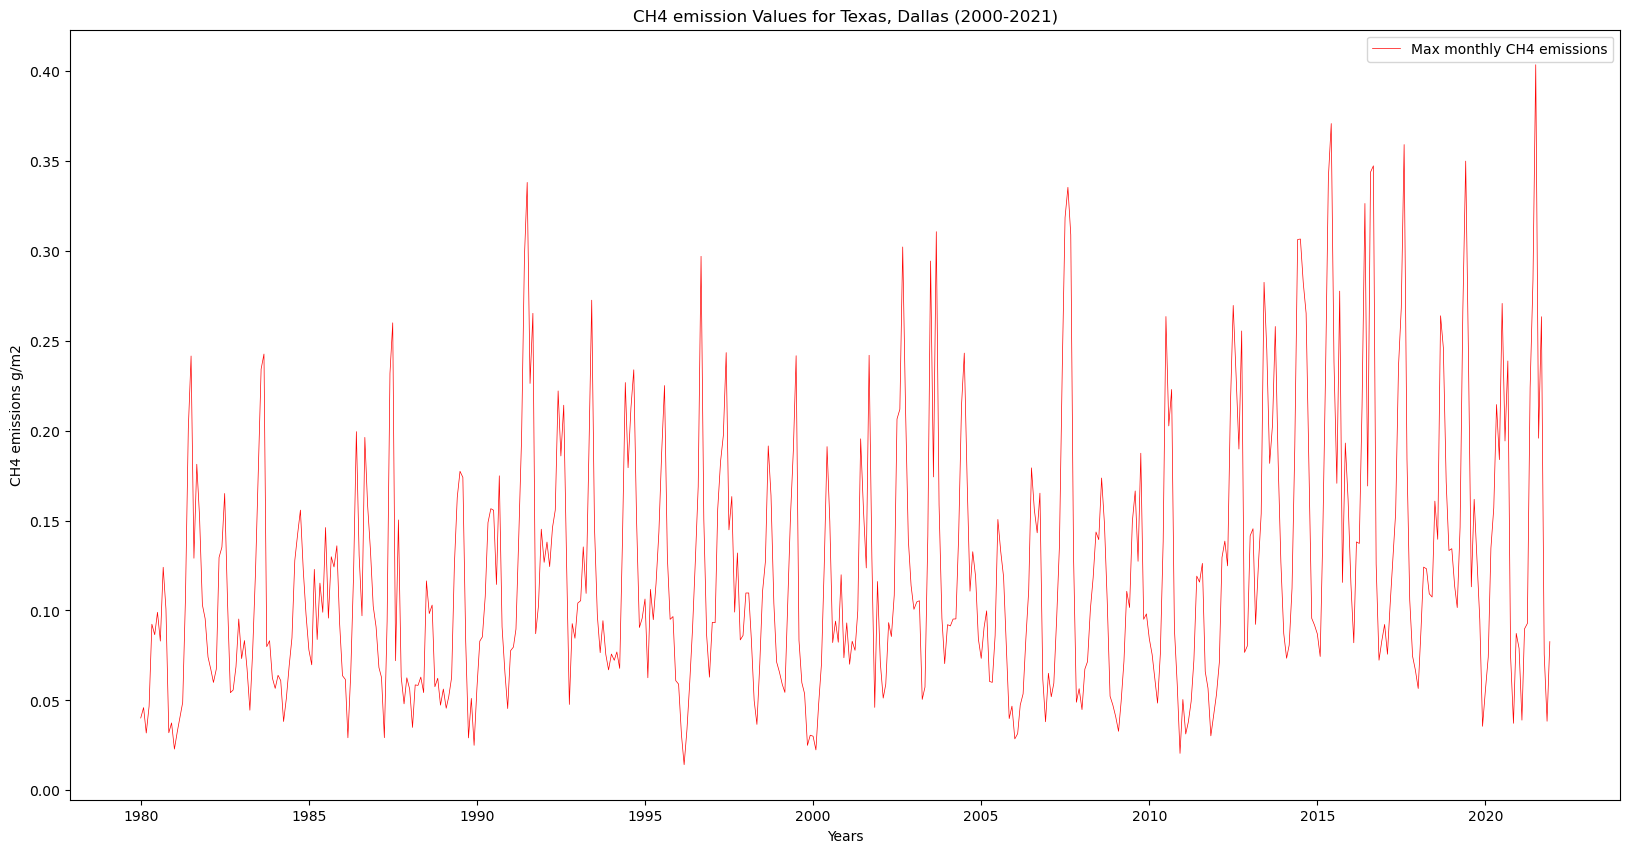

In [19]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 10))


plt.plot(
    df["date"],
    df["max"],
    color="red",
    linestyle="-",
    linewidth=0.5,
    label="Max monthly CH4 emissions",
)

plt.legend()
plt.xlabel("Years")
plt.ylabel("CH4 emissions g/m2")
plt.title("CH4 emission Values for Texas, Dallas (1980-2021)")

In [20]:
print(items[2]["properties"]["start_datetime"])

2021-10-01T00:00:00+00:00


In [21]:
october_tile = requests.get(
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items[2]['collection']}&item={items[2]['id']}"
    "&assets=ch4-wetlands-emissions"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}",
).json()
october_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://2qncpyg24c.execute-api.us-west-2.amazonaws.com/api/raster/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=nasa-gsfc-ch4-wetlands-emissions&item=nasa-gsfc-ch4-wetlands-emissions-202110&assets=ch4-wetlands-emissions&color_formula=gamma+r+1.05&colormap_name=magma&rescale=0.0%2C0.2'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 180.0, 90.0],
 'center': [0.0, 0.0, 0]}

In [23]:
# Use bbox initial zoom and map
# Set up a map located w/in event bounds
import folium

aoi_map_bbox = Map(
    tiles="OpenStreetMap",
    location=[
        30,-100
    ],
    zoom_start=8,
)

map_layer = TileLayer(
    tiles=october_tile["tiles"][0],
    attr="GHG", opacity = 0.5
)

map_layer.add_to(aoi_map_bbox)

aoi_map_bbox

## Summary
In this notebook, we have successfully explored, analyzed, and visualized the STAC collection for wetland methane emissions.